# Data Visualization
In this section, we focus on the **Top 25 drugs ranked by total spending**, using the cleaned dataset `top_cost.csv` produced in the data preparation stage. This dataset aggregates spending across all payers and reports total system-level costs, utilization measures, and drug characteristics such as drug category. The purpose of this visualization notebook is to **explore patterns and relationships** in the cleaned outputs through descriptive visual analysis. 

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Paths relative to notebooks/
DATA_DIR = Path("../data")
RESULTS_DIR = Path("../results")
IMAGE_DIR = Path("../images")
IMAGE_DIR.mkdir(parents=True, exist_ok=True)

TOP_COST_PATH = DATA_DIR / "top_cost.csv"
PAYER_COST_PATH = DATA_DIR / "payer_cost.csv"

In [3]:
top_cost = pd.read_csv(TOP_COST_PATH)

### Minimal type normalization for visualization

The cleaned CSV files store monetary values and counts as formatted strings (e.g., `$658,455,118` or `98,904`).  
To ensure numeric variables are correctly interpreted by plotting libraries, we apply minimal type normalization.  
This step does not alter the structure of the data or introduce additional cleaning decisions.

In [4]:
def money_to_float(s: pd.Series) -> pd.Series:
    return pd.to_numeric(
        s.astype(str).str.replace(r"[$,]", "", regex=True),
        errors="coerce"
    )

def comma_int_to_float(s: pd.Series) -> pd.Series:
    return pd.to_numeric(
        s.astype(str).str.replace(",", "", regex=False),
        errors="coerce"
    )

def prep_cost_df(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    if "Rank" in out.columns:
        out["Rank"] = pd.to_numeric(out["Rank"], errors="coerce")

    money_cols = [
        "TotalCost",
        "AverageCostperUnit",
        "Out-of-Pocket Median",
        "Out-of-Pocket25P",
        "Out-of-Pocket75P",
    ]
    for c in money_cols:
        if c in out.columns:
            out[c] = money_to_float(out[c])

    int_cols = ["NumberofPrescriptions", "NumberofIndividuals"]
    for c in int_cols:
        if c in out.columns:
            out[c] = comma_int_to_float(out[c])

    return out

top_cost_clean = prep_cost_df(top_cost)
top_cost_clean[["TotalCost", "NumberofPrescriptions", "Rank"]].head()

,TotalCost,NumberofPrescriptions,Rank
0,658455118,98904,1.0
1,487220554,22973,2.0
2,400942148,70151,3.0
3,386458748,66878,4.0
4,291401313,56823,5.0


## How does total drug spending decline across the Top 25 ranks, and how does this pattern differ by drug category?

To examine the concentration of drug spending among the highest-cost medications, we plot **TotalCost against rank** for the Top 25 costliest drugs, stratified by **drug category**. Rank 1 corresponds to the single most expensive drug, with higher ranks indicating progressively lower total spending.

Because the Top 25 cost table aggregates spending across all payers, payer type does not vary within this dataset. Drug category, however, captures meaningful structural differences in pricing and utilization, making it a natural dimension for comparison.


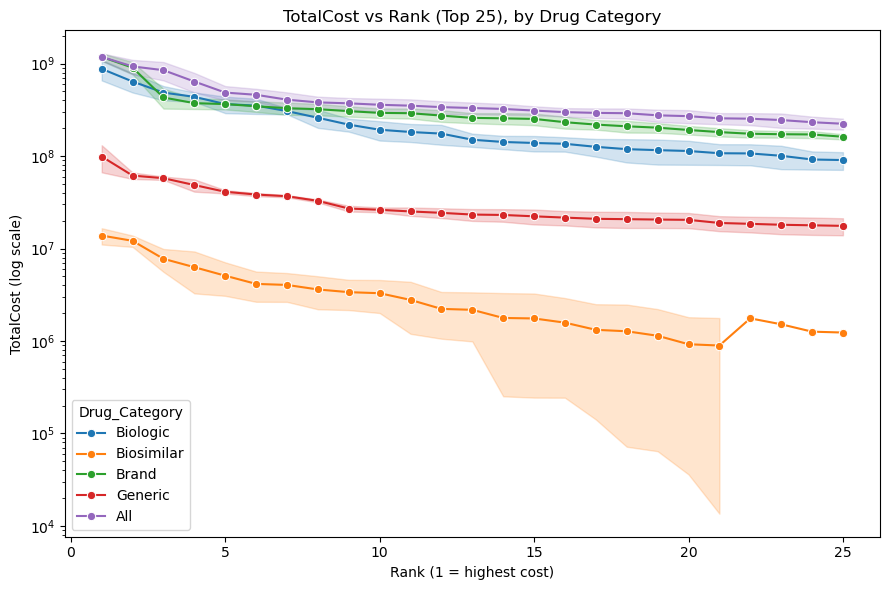

In [5]:
df = top_cost_clean.dropna(subset=["Rank", "TotalCost"])
plot_df = df.dropna(subset=["Rank", "TotalCost", "Drug_Category"])

plt.figure(figsize=(9, 6))
sns.lineplot(
    data=plot_df,
    x="Rank",
    y="TotalCost",
    hue="Drug_Category",
    marker="o"
)
plt.yscale("log")
plt.title("TotalCost vs Rank (Top 25), by Drug Category")
plt.xlabel("Rank (1 = highest cost)")
plt.ylabel("TotalCost (log scale)")
plt.tight_layout()
plt.savefig(IMAGE_DIR / "rank_vs_totalcost_by_drug_category.png", dpi=300)
plt.show()

The figure reveals a pronounced concentration of total drug spending among the highest-ranked drugs, with spending declining gradually as rank increases. This pattern is most pronounced for **biologic and brand-name drugs**, which dominate the top ranks and maintain substantially higher spending levels across the entire Top 25 distribution.

In contrast, **generic and biosimilar drugs** exhibit much lower total costs and a flatter decline across ranks, reflecting lower per-unit prices and, in some cases, more dispersed utilization. The separation between drug categories persists even at lower ranks, indicating that category-level characteristics play a central role in shaping aggregate spending outcomes.

Overall, this visualization highlights how system-level drug expenditures are disproportionately driven by a small number of high-cost biologic and brand-name drugs, reinforcing the highly skewed nature of pharmaceutical spending.


## How does the concentration of total drug spending differ across drug categories?

While the previous figure compared spending patterns across drug categories within a single panel, it can be difficult to assess category-specific dynamics when scales differ substantially. To address this, we examine **TotalCost versus rank separately for each drug category** using faceted panels.

Each panel displays the Top 25 drugs within a given category, allowing us to compare how quickly spending declines from the highest-ranked drug and how concentrated costs are within each category. A logarithmic scale is used to facilitate comparison across orders of magnitude.


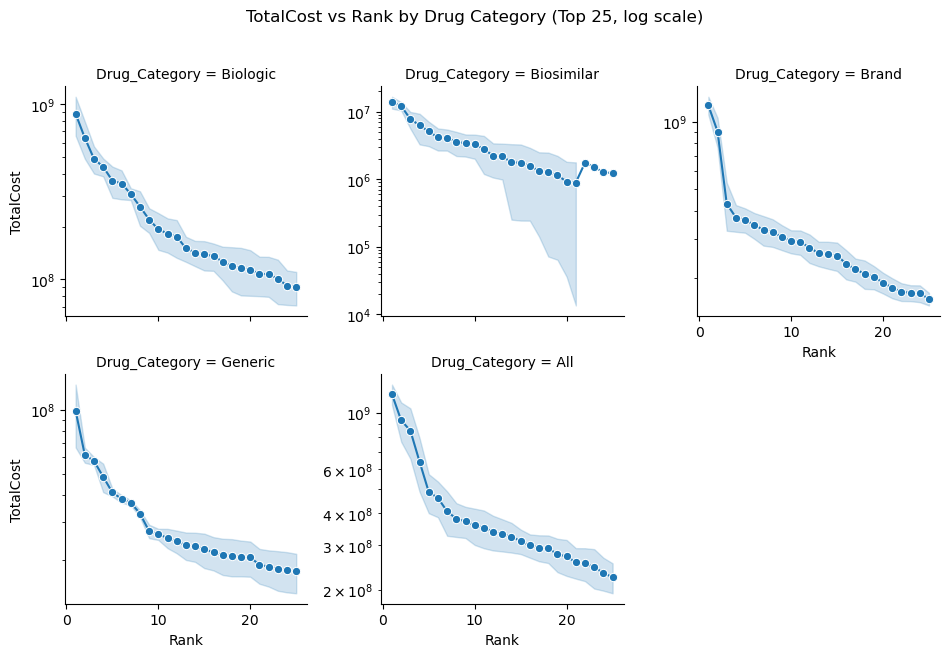

In [6]:
plot_df = df.dropna(subset=["Rank", "TotalCost", "Drug_Category"])

g = sns.FacetGrid(
    plot_df,
    col="Drug_Category",
    col_wrap=3,
    height=3.2,
    sharey=False
)
g.map_dataframe(
    sns.lineplot,
    x="Rank",
    y="TotalCost",
    marker="o"
)

for ax in g.axes.flatten():
    ax.set_yscale("log")

g.fig.suptitle("TotalCost vs Rank by Drug Category (Top 25, log scale)", y=1.02)
g.fig.tight_layout()
g.fig.savefig(IMAGE_DIR / "rank_vs_totalcost_facet_drug_category.png", dpi=300)
plt.show()

The faceted plots reveal substantial heterogeneity in spending concentration across drug categories. **Biologic and brand-name drugs** exhibit extremely high spending at the top ranks, followed by a steep initial decline, indicating that a small number of drugs account for a large share of category-level expenditures.

In contrast, **generic drugs** display lower overall spending levels and a more gradual decline across ranks, reflecting lower prices and less extreme concentration. **Biosimilar drugs** show the lowest spending levels among the categories, with greater variability across ranks, likely due to smaller sample sizes and heterogeneous adoption patterns.

## Are the most expensive drugs also the most frequently prescribed?

High total drug spending can arise through different mechanisms: a drug may be widely prescribed, very expensive per treatment, or both. To explore this distinction, we examine the relationship between **TotalCost** and **Number of Prescriptions** among the Top 25 costliest drugs.

By plotting total spending against prescription volume and stratifying observations by **drug category**, we assess whether high system-level costs are primarily driven by utilization or by high prices. A logarithmic scale is applied to total cost to accommodate the large variation in spending levels across drugs.

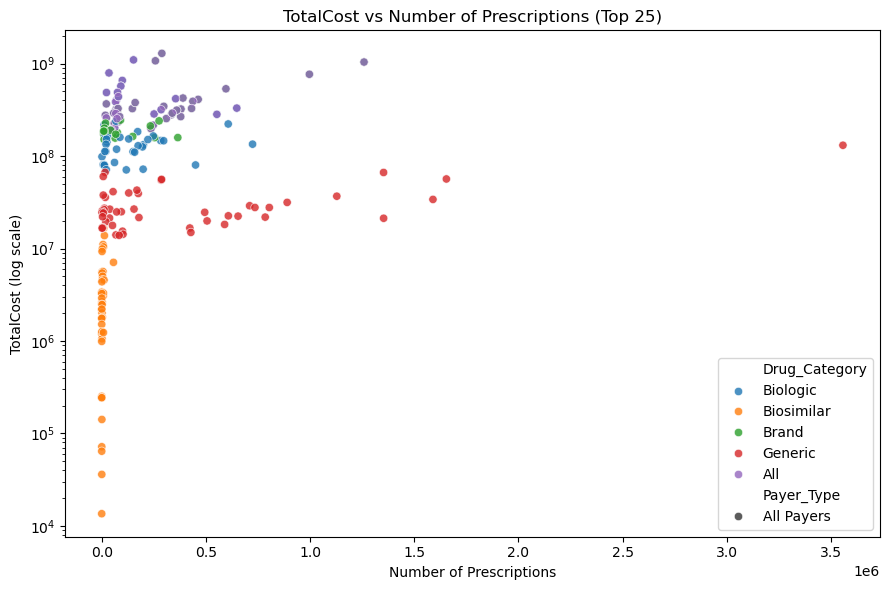

In [9]:
plot_df = df.dropna(subset=["TotalCost", "NumberofPrescriptions", "Drug_Category", "Payer_Type"])

plt.figure(figsize=(9, 6))
sns.scatterplot(
    data=plot_df,
    x="NumberofPrescriptions",
    y="TotalCost",
    hue="Drug_Category",
    style="Payer_Type",
    alpha=0.8
)
plt.yscale("log")
plt.title("TotalCost vs Number of Prescriptions (Top 25)")
plt.xlabel("Number of Prescriptions")
plt.ylabel("TotalCost (log scale)")
plt.tight_layout()
plt.savefig(IMAGE_DIR / "totalcost_vs_prescriptions.png", dpi=300)
plt.show()

The scatter plot reveals a weak and highly heterogeneous relationship between prescription volume and total spending. Several drugs with extremely high total costs are associated with relatively modest numbers of prescriptions, indicating that **high prices per treatment episode**, rather than widespread utilization, are a key driver of overall spending for these drugs.

This pattern is especially evident among **biologic drugs**, which cluster at high total cost levels even at low to moderate prescription volumes. In contrast, **generic drugs** tend to exhibit higher prescription counts but substantially lower total costs, reflecting lower per-unit prices. **Biosimilars** occupy the lowest-cost region of the plot, with limited prescription volumes and relatively small contributions to aggregate spending.

Overall, these results suggest that policies focused solely on reducing utilization may have limited impact on total drug spending. Instead, pricing dynamics and reimbursement structures play a central role in driving expenditures for the most costly drugs.


## How does prescription volume vary by drug category over time among the most frequently prescribed drugs?

So far, we have focused on cross-sectional relationships between total cost, rank, and drug characteristics. We now turn to a time-based comparison using the Top-25 Frequency dataset to examine how **prescription volume changes across years** for different drug categories.

Specifically, this visualization asks:

**Among the drugs that appear in the Top-25 most frequently prescribed list, how does total prescription volume differ by drug category, and how did this distribution change between 2021 and 2022?**

To answer this question, we aggregate the total number of prescriptions by **drug category** and **year**, summing prescription counts across all Top-25 frequency drugs within each group. This allows us to compare utilization patterns across categories and observe year-to-year shifts.

In [11]:
freq = pd.read_csv(DATA_DIR / "top_freq.csv")
freq.head()

,TableType,Top25Type,Year,Drug_Category,Payer_Type,Rank,National_Drug_Code,Drug_Name,NumberofPrescriptions,NumberofIndividuals,TotalCost,AverageCostperUnit,AverageDispensedUnitsPerFill,DrugUnitofMeasure,Out-of-Pocket Median,Out-of-Pocket25P,Out-of-Pocket75P,OOPZeroCount
0,Top 25 List Overall,Freq,2021,Biologic,All Payers,1.0,8.822190e+07,Lantus SoloStar,"552,731","131,318","$283,095,982",$26.76,19,ML,$10.00,$1.33,$31.50,18.9%
1,Top 25 List Overall,Freq,2021,Biologic,All Payers,2.0,5.816008e+10,Shingrix,"450,363","342,827","$80,175,227",$177.60,1,EA,$9.20,$0.00,$47.00,37.0%
2,Top 25 List Overall,Freq,2021,Biologic,All Payers,3.0,2.831501e+06,HumuLIN N,"301,369","98,977","$61,651,560",$3.91,52,ML,$6.67,$3.33,$10.00,6.1%
3,Top 25 List Overall,Freq,2021,Biologic,All Payers,4.0,8.822203e+07,Lantus,"283,200","72,425","$147,240,425",$21.48,24,ML,$10.00,$0.00,$31.33,25.8%
4,Top 25 List Overall,Freq,2021,Biologic,All Payers,5.0,2.143480e+06,Trulicity,"251,337","49,617","$285,686,243",$418.17,3,ML,$17.50,$1.33,$45.00,14.4%


In [29]:
df2 = freq.copy()

if "Rank" in df2.columns:
    df2["Rank"] = pd.to_numeric(df["Rank"], errors="coerce")

# prescriptions often look like "98,904"
if "NumberofPrescriptions" in df2.columns:
    df2["NumberofPrescriptions"] = pd.to_numeric(
        df2["NumberofPrescriptions"].astype(str).str.replace(",", "", regex=False),
        errors="coerce"
    )

df2[["Rank", "NumberofPrescriptions"]].head()

,Rank,NumberofPrescriptions
0,1.0,552731
1,2.0,450363
2,3.0,301369
3,4.0,283200
4,5.0,251337


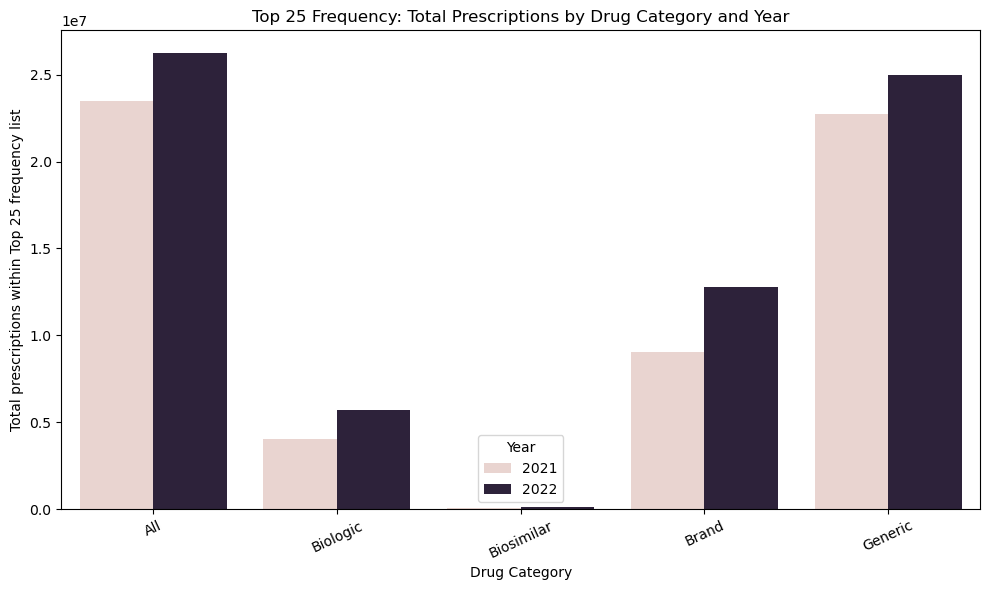

In [30]:
plot_df2 = df2.dropna(subset=["Drug_Category", "NumberofPrescriptions", "Year"])

cat_year = (
    plot_df2.groupby(["Year", "Drug_Category"])["NumberofPrescriptions"]
    .sum()
    .reset_index()
)

plt.figure(figsize=(10, 6))
sns.barplot(data=cat_year, x="Drug_Category", y="NumberofPrescriptions", hue="Year")
plt.title("Top 25 Frequency: Total Prescriptions by Drug Category and Year")
plt.xlabel("Drug Category")
plt.ylabel("Total prescriptions within Top 25 frequency list")
plt.xticks(rotation=25)
plt.tight_layout()
plt.savefig(IMAGE_DIR / "top_freq_prescriptions_by_category_year.png", dpi=300)
plt.show()


The bar chart shows clear and consistent differences in prescription volume across drug categories. Generic drugs account for the largest share of prescriptions in both years, reflecting their widespread use and lower barriers to access. Brand drugs also exhibit high utilization, though at a lower level than generics.

Across nearly all categories, total prescription counts increase from 2021 to 2022, suggesting rising utilization among the most frequently prescribed drugs. This increase is particularly noticeable for generic and brand drugs, which may reflect broader demand growth or changes in treatment patterns.

In contrast, biologic and biosimilar drugs contribute relatively smaller shares of total prescriptions within the Top-25 frequency list. This pattern highlights an important distinction between utilization and cost: drugs that are prescribed most often are not necessarily those that drive the highest spending.

Overall, this visualization complements earlier cost-focused analyses by showing that high prescription frequency is concentrated in lower-cost categories, reinforcing the idea that healthcare spending and healthcare utilization capture different dimensions of the pharmaceutical market.


## How does median total drug spending differ across payer types among the Top 25 drugs?

In this section, we analyze payer-level variation in drug spending using the **Top 25 Payer Median** dataset (`payer_med.csv`). This dataset reports, for each payer type (Commercial, Medicare, and Medi-Cal), the median total cost associated with the top-ranked drugs in terms of spending.

We focus on **median total drug cost** as the outcome of interest and compare its distribution across payer types using a boxplot on a log scale. This visualization allows us to assess not only differences in central tendency, but also the spread and presence of high-cost outliers across payer groups. The goal is to explore whether payer structure is associated with systematically higher or lower drug spending among the most costly drugs.


In [27]:
payer_med = pd.read_csv(DATA_DIR / "payer_med.csv")
payer_med_clean = prep_cost_df(payer_med)
payer_med_clean.head()

,TableType,Top25Type,Year,Drug_Category,Payer_Type,Rank,National_Drug_Code,Drug_Name,NumberofPrescriptions,NumberofIndividuals,TotalCost,AverageCostperUnit,AverageDispensedUnitsPerFill,DrugUnitofMeasure,Out-of-Pocket Median,Out-of-Pocket25P,Out-of-Pocket75P,OOPZeroCount
0,Top 25 Payer,Median,2021,Biologic,Commercial,1.0,2.814901e+06,Humatrope,609,77,5216046,3239.78,3,EA,250.00,50.00,319.90,1.3%
1,Top 25 Payer,Median,2021,Biologic,Commercial,2.0,5.024201e+10,Nutropin AQ NuSpin 20,3043,336,21656998,1225.22,6,ML,250.00,85.62,293.53,3.6%
2,Top 25 Payer,Median,2021,Biologic,Commercial,3.0,2.144527e+06,Taltz,521,257,5532414,5571.41,2,ML,250.00,50.00,250.00,10.5%
3,Top 25 Payer,Median,2021,Biologic,Commercial,4.0,2.144509e+06,Taltz,281,188,4142101,5515.45,3,ML,250.00,50.00,250.00,5.9%
4,Top 25 Payer,Median,2021,Biologic,Commercial,5.0,5.024201e+10,Nutropin AQ NuSpin 10,5803,622,24656985,610.22,7,ML,237.14,86.39,271.43,2.4%


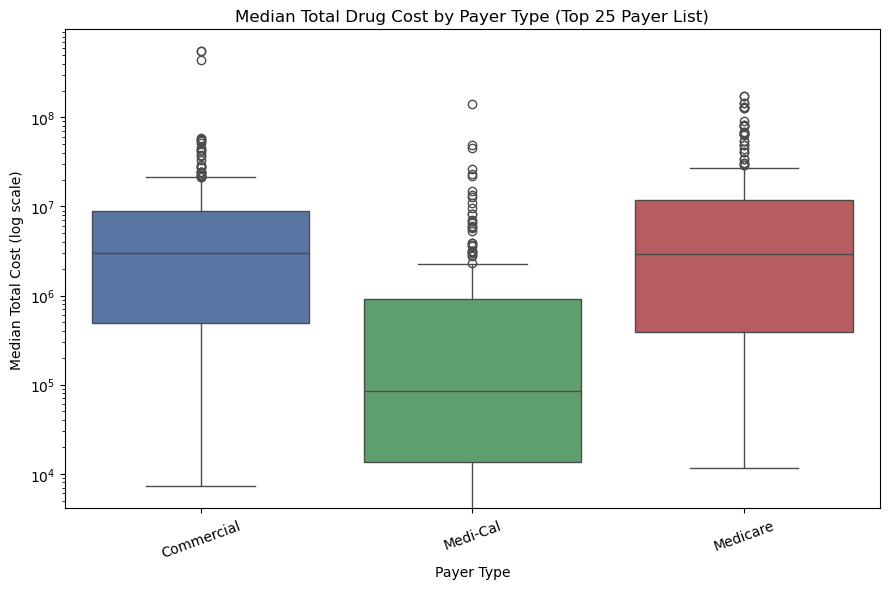

In [28]:
plot_df3 = payer_med_clean.dropna(
    subset=["TotalCost", "Payer_Type"]
)

payer_palette = {
    "Commercial": "#4C72B0",  
    "Medi-Cal": "#55A868",    
    "Medicare": "#C44E52",   
}

plt.figure(figsize=(9, 6))
sns.boxplot(
    data=plot_df3,
    x="Payer_Type",
    y="TotalCost",
    palette=payer_palette
)

plt.yscale("log")
plt.title("Median Total Drug Cost by Payer Type (Top 25 Payer List)")
plt.xlabel("Payer Type")
plt.ylabel("Median Total Cost (log scale)")
plt.xticks(rotation=20)
plt.tight_layout()
plt.savefig(IMAGE_DIR / "payer_med_totalcost_by_payer.png", dpi=300)
plt.show()

The distribution of median total drug costs differs substantially across payer types. Commercial and Medicare plans exhibit higher median costs and wider dispersion, indicating both higher typical spending and greater variability among high-cost drugs.

In contrast, Medi-Cal shows a markedly lower median total cost and a tighter interquartile range. This suggests that Medi-Cal generally pays less for the same high-cost drugs, likely reflecting stronger price negotiation, formulary restrictions, or reimbursement caps.

Notably, all payer types exhibit extreme upper-tail outliers, highlighting that certain specialty drugs remain expensive regardless of payer. However, the consistently lower central tendency for Medi-Cal indicates that payer type plays a significant role in shaping drug cost exposure beyond drug characteristics alone.

To conclude, this visualization demonstrates that differences in pharmaceutical spending are not driven solely by which drugs are prescribed, but also by **who is paying for them**.
